In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


import warnings
warnings.filterwarnings('ignore')

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle

In [2]:
#reading data
df=pd.read_csv("../datasets/df_final.csv")
df.tail()

,subreddit,sentiment,cleaned_text,simpe_class
39891,1,0.2732,trump begin witchhunt green seek name departm...,1
39892,1,0.5859,new report switch clean economy irrevocably u...,0
39893,1,0.4404,buy v lease solar panel option better homeowner,1
39894,1,0.0000,residential solar water heater idea,1
39895,1,0.0000,port long beach go greener solar carport,1


In [3]:
df.isnull().sum()

subreddit       0
sentiment       0
cleaned_text    0
simpe_class     0
dtype: int64

In [4]:
df.shape

(39896, 4)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.shape

(38686, 4)

## Model

In [7]:
get_text_data = FunctionTransformer(lambda x: x['cleaned_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['simpe_class','sentiment']], validate = False)

In [8]:
X = df[['cleaned_text','simpe_class','sentiment']]
y = df['subreddit']

In [9]:
# Check what we need to check in a classification problem.
y.value_counts()

1    19378
0    19308
Name: subreddit, dtype: int64

In [10]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

## Logisitic regression Modeling with Pipeline and Grid search

In [11]:
pipe_v3 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression(solver="liblinear"))
])

params = {
    
    
        'logreg__penalty' : ['l1','l2'],
        'logreg__C' : [0.01,0.1],
        #'logreg__solver' : ['liblinear'],
        #'features__text_features__cvec__stop_words' : ["power","plant"]
       'features__text_features__cvec__ngram_range': [(1,1),(1,2)],
        'features__text_features__cvec__max_features': [5000],
     #'features__text_features__cvec__min_df': [2],
        #'features__text_features__cvec__max_df': [ .9]
        
    
}

gs_lr = GridSearchCV(pipe_v3, params, cv=5)

gs_lr.fit(X_train, y_train)
gs_lr.score(X_train, y_train)

0.7192710352849941

In [12]:
gs_lr.best_params_

{'features__text_features__cvec__max_features': 5000,
 'features__text_features__cvec__ngram_range': (1, 1),
 'logreg__C': 0.1,
 'logreg__penalty': 'l2'}

In [13]:
gs_lr.score(X_test, y_test)

0.6473248901524942

In [14]:
type(gs_lr.best_estimator_)

sklearn.pipeline.Pipeline

In [15]:
def nice_conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [16]:
# build a function to print out a nice confusion matrix
preds = gs_lr.best_estimator_.predict(X_test)

nice_conmat(y_test, preds, ['energy', 'renewable_energy'])

Accuracy Score: 0.6473248901524942


,Predicted energy,Predicted renewable_energy
Actual energy,2404,1458
Actual renewable_energy,1271,2605


In [17]:
class_names=["Renewable_Energy","Energy"]

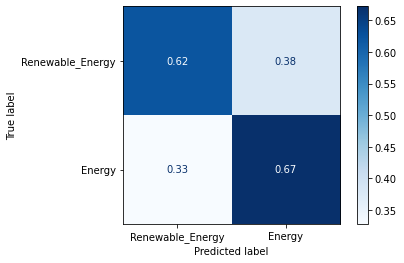

In [18]:
plot_confusion_matrix(gs_lr,
                      X_test,
                      y_test,
                      display_labels=class_names,
                     cmap=plt.cm.Blues,
                    normalize="true",
                     );
plt.savefig('../plots/cf_reg_cvec.png')

## getting model coefficients

In [19]:
features = gs_lr.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()
coefficients = gs_lr.best_estimator_.named_steps['logreg'].coef_[0]

coef_df=pd.DataFrame({'features': ['sentiment','simpe_class']+ features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients]
             })

In [20]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df.head(10)

,coef,exp_coef
features,,
hawaii,0.993917,2.701797
career,0.805047,2.236802
synthetic,0.714997,2.044181
cat,0.638260,1.893184
fission,0.633168,1.883568
tidal,0.629071,1.875868
location,0.624563,1.867430
hawaiian,0.624196,1.866744
awesome,0.624161,1.866680


In [21]:
coef_df

,coef,exp_coef
features,,
hawaii,0.993917,2.701797
career,0.805047,2.236802
synthetic,0.714997,2.044181
cat,0.638260,1.893184
fission,0.633168,1.883568
...,...,...
sticker,-0.797189,0.450594
coronavirus,-0.798506,0.450001
oil,-0.804492,0.447315


In [22]:
coef_df['exp_coef'].tail(10).sort_values(ascending = False)

features
saudi          0.524891
barrel         0.514335
lng            0.470097
bailout        0.465449
hydrogen       0.465126
sticker        0.450594
coronavirus    0.450001
oil            0.447315
shale          0.441844
opec           0.422077
Name: exp_coef, dtype: float64

In [23]:
coef_df['exp_coef'].head(10).sort_values(ascending = False)

features
hawaii       2.701797
career       2.236802
synthetic    2.044181
cat          1.893184
fission      1.883568
tidal        1.875868
location     1.867430
hawaiian     1.866744
awesome      1.866680
li           1.823059
Name: exp_coef, dtype: float64

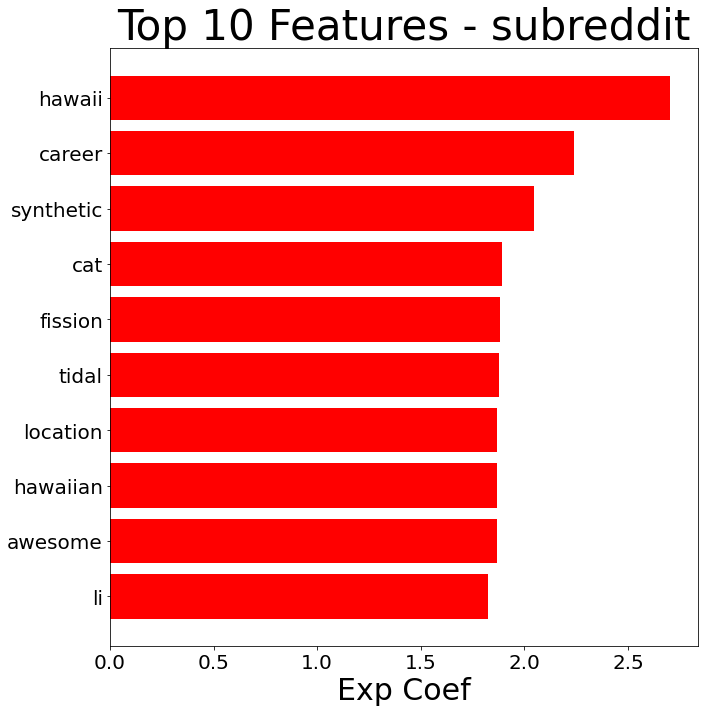

In [24]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(10,10))
plt.barh(labels, weights, color = 'red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - subreddit', fontsize=42)
plt.tight_layout()
plt.savefig('../plots/top_coef_reg_cvec.png', dpi=235)

In [25]:
y_scores = gs_lr.predict_proba(X_test)[:, 1]

In [26]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

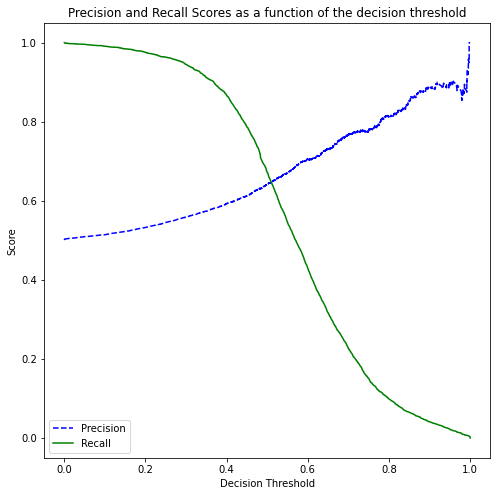

In [28]:
plot_precision_recall_vs_threshold(p,r,thresholds)
plt.savefig('../plots/precsion_reg_cvec.png', dpi=235)

## With TFIDF Log reg

In [29]:
pipe_v3 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('tvec', TfidfVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression(solver="liblinear"))
])

params = {
      
        
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__C' : [0.1,1],
        'features__text_features__tvec__ngram_range': [(1,1),(1,2)],
        'features__text_features__tvec__max_features':[5000]
        #'features__text_features__tvec__min_df': [3],
        #'features__text_features__tvec__max_df': [0.4,.6, .9]
    
}

gs_lr_tvec = GridSearchCV(pipe_v3, params, cv=5)

gs_lr_tvec.fit(X_train, y_train)
gs_lr_tvec.score(X_train, y_train)

0.7298694584464263

In [30]:
gs_lr_tvec.best_params_

{'features__text_features__tvec__max_features': 5000,
 'features__text_features__tvec__ngram_range': (1, 2),
 'logreg__C': 1,
 'logreg__penalty': 'l2'}

In [31]:
gs_lr_tvec.score(X_test, y_test)

0.6583096407340399

In [32]:
# build a function to print out a nice confusion matrix
preds = gs_lr_tvec.best_estimator_.predict(X_test)

nice_conmat(y_test, preds, ['energy', 'renewable_energy'])

Accuracy Score: 0.6583096407340399


,Predicted energy,Predicted renewable_energy
Actual energy,2436,1426
Actual renewable_energy,1218,2658


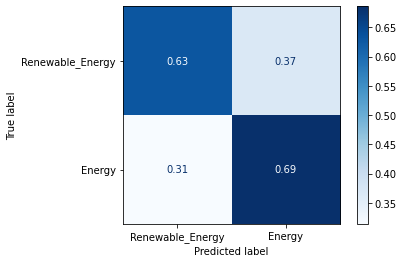

In [33]:

plot_confusion_matrix(gs_lr_tvec,
                      X_test,
                      y_test,
                      display_labels=class_names,
                     cmap=plt.cm.Blues,
                    normalize="true",
                     );
plt.savefig('../plots/cf_reg_tvec.png')

In [34]:
features = gs_lr_tvec.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['tvec'].get_feature_names()
coefficients = gs_lr_tvec.best_estimator_.named_steps['logreg'].coef_[0]

coef_df=pd.DataFrame({'features': ['sentiment','simpe_class']+ features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients]
             })

In [35]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df.head(10)

,coef,exp_coef
features,,
hawaii,3.224830,25.149286
career,2.391205,10.926653
location,2.046414,7.740092
awesome,2.027864,7.597837
etc,1.971999,7.185025
engineering,1.887901,6.605490
cleantech,1.831064,6.240520
election,1.823052,6.190724
hawaiian,1.789500,5.986456


In [36]:
coef_df['exp_coef'].head(10).sort_values()

features
cat             5.876563
hawaiian        5.986456
election        6.190724
cleantech       6.240520
engineering     6.605490
etc             7.185025
awesome         7.597837
location        7.740092
career         10.926653
hawaii         25.149286
Name: exp_coef, dtype: float64

In [37]:
coef_df['exp_coef']["california"]

1.0752417809853303

In [38]:
coef_df['exp_coef'].tail(10).sort_values()

features
hydrogen       0.008184
oil            0.011109
shale          0.032359
opec           0.068035
sticker        0.077815
bailout        0.085142
coronavirus    0.085389
lng            0.087623
saudi          0.093045
worker         0.112097
Name: exp_coef, dtype: float64

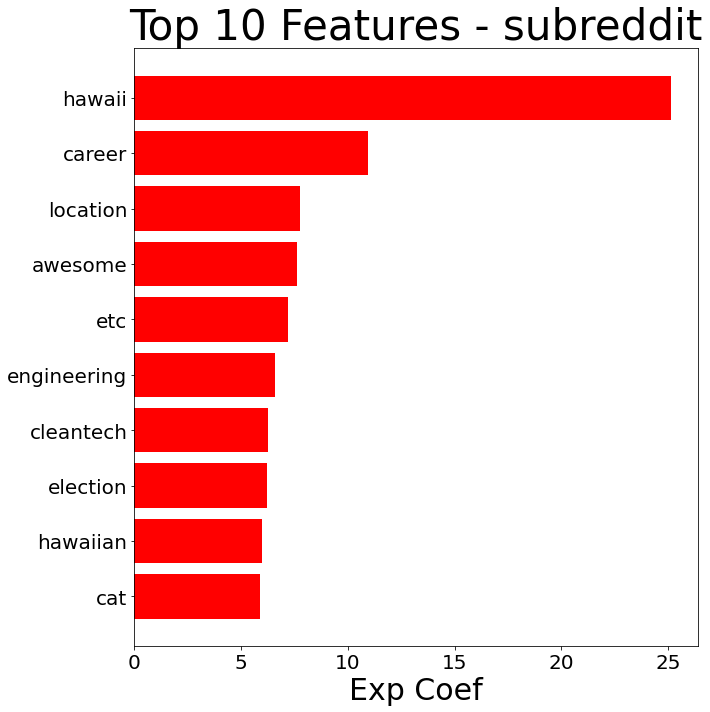

In [39]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(10,10))
plt.barh(labels, weights, color = 'red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - subreddit', fontsize=42)
plt.tight_layout()
plt.savefig('../plots/top_coef_reg_tvec.png', dpi=235)

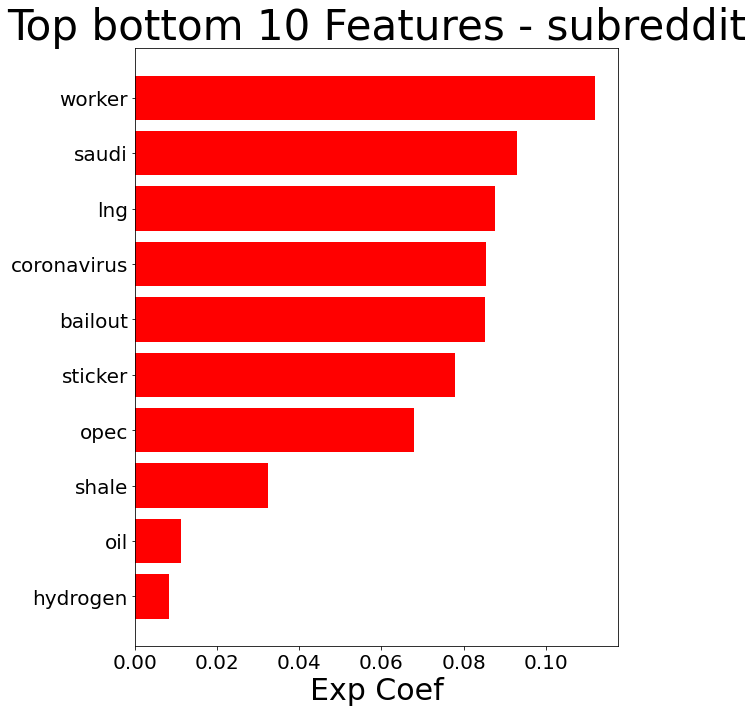

In [40]:
weights = coef_df['exp_coef'].tail(10).sort_values()
labels = weights.index

plt.figure(figsize=(10,10))
plt.barh(labels, weights, color = 'red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top bottom 10 Features - subreddit', fontsize=42)
plt.tight_layout()
plt.savefig('../plots/top__bottom_coef_reg_tvec.png', dpi=235)

In [41]:
a=[]
for i,items in enumerate(df["cleaned_text"]):
    if "hawaii" in items.split():
        a.append(i)
        
df[df.index.isin(a)][df["subreddit"]==0]     

,subreddit,sentiment,cleaned_text,simpe_class
4030,0,-0.7003,would like see try lol whole point phev rarely...,0
4081,0,0.5499,believe one executive bmw big bevs left compan...,0
10245,0,-0.1280,u drilling rig count drop rig month,0
13175,0,0.2732,conservation week,0
14972,0,0.0000,searching spray dryer get know everything spra...,0
15938,0,0.2732,new michael moore backed doc tackle alternative,0
15963,0,0.2732,wind industry exceed bn revenue,1
16606,0,0.6801,world first aberdeen city order double decker ...,0
16729,0,0.2960,time get serious recycling lithium ion battery...,0
17850,0,0.0000,world second epr nuclear reactor start work china,0


### KNN with pipeline and grid search 

In [42]:
pipe_v3 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('knn', KNeighborsClassifier())
])

params = {
        'knn__n_neighbors':[12],
        #'knn__p':[1,2],#1 is manhattan and 2 is euclidian 
        #'cvec__stop_words' : [None, 'english'],
        'features__text_features__cvec__max_features': [5000],
        'features__text_features__cvec__min_df': [2],
        #'features__text_features__cvec__max_df': [.4,0.5]
}
gs_knn = GridSearchCV(pipe_v3, params, cv=5)

gs_knn.fit(X_train, y_train)
gs_knn.score(X_train, y_train)
  

0.6783960191288613

In [43]:
gs_knn.best_params_

{'features__text_features__cvec__max_features': 5000,
 'features__text_features__cvec__min_df': 2,
 'knn__n_neighbors': 12}

In [44]:
gs_knn.score(X_test, y_test)

0.5781855776686482

In [45]:
# build a function to print out a nice confusion matrix
preds = gs_knn.best_estimator_.predict(X_test)

cf_knn=nice_conmat(y_test, preds, ['energy', 'renewable_energy'])

Accuracy Score: 0.5781855776686482


In [46]:
cf_knn

,Predicted energy,Predicted renewable_energy
Actual energy,2511,1351
Actual renewable_energy,1913,1963


In [47]:
class_names=["Renewable_Energy","Energy"]

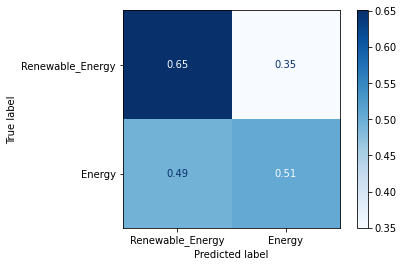

In [48]:

plot_confusion_matrix(gs_knn,
                      X_test,
                      y_test,
                      display_labels=class_names,
                     cmap=plt.cm.Blues,
                    normalize="true",
                     );
plt.savefig('../plots/cf_knn.png', dpi=235)

In [49]:
y_scores = gs_knn.predict_proba(X_test)[:, 1]

In [50]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

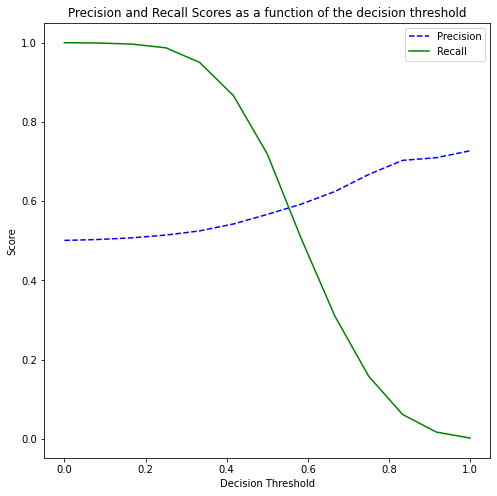

In [51]:
plot_precision_recall_vs_threshold(p,r,thresholds)
plt.savefig('../plots/precision_knn.png', dpi=235)

### Comparing models with ROC AUC curves

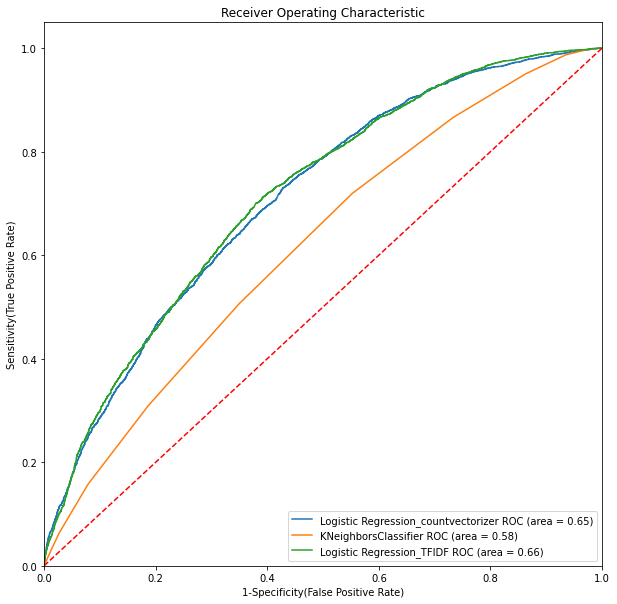

In [52]:
models = [
{
    'label': 'Logistic Regression_countvectorizer',
    'model':gs_lr,
},
{
    'label': 'KNeighborsClassifier',
    'model': gs_knn,
},
    {
    'label': 'Logistic Regression_TFIDF',
    'model':gs_lr_tvec,
}
]
plt.figure(figsize=(10,10))
# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../plots/roc_auc.png', dpi=235)
#plt.show()   # Display